In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import random as r
from scipy.stats import pearsonr


In [34]:
#reading the data

X = pd.read_csv("train_t0.csv")
X.drop('ID', inplace=True, axis=1)
Y = pd.read_csv("train_t1.csv")
Y.drop('ID', inplace=True, axis=1)
test = pd.read_csv("test_t0.csv")
test.drop('ID', inplace=True, axis=1)


In [35]:
sel = VarianceThreshold()
x = sel.fit_transform(X)
pca = PCA(25)
transformed_x= pca.fit_transform(x)
test_data = sel.transform(test)
test_data = pca.transform(test_data)

In [36]:
clf = RandomForestRegressor(n_estimators=100).fit(transformed_x, Y)
rforestprediction = clf.predict(test_data)

In [37]:
regr = BaggingRegressor(n_estimators=100).fit(transformed_x, Y)
baggingprediction = regr.predict(test_data)

In [38]:
ada =  MultiOutputRegressor(AdaBoostRegressor(n_estimators=100)).fit(transformed_x, Y)
adaprediction = ada.predict(test_data)

In [39]:
ridge = MultiOutputRegressor(Ridge(random_state=1773)).fit(transformed_x, Y)
ridgeprediction = ridge.predict(test_data)

In [40]:
def printpredictions(modeltype):
    print(modeltype)
    if modeltype==0:
        prediction = adaprediction
        
    elif modeltype==1:
        prediction = baggingprediction
        
    elif modeltype==2:
        prediction = rforestprediction
    
    elif modeltype==3:
        prediction = ridgeprediction
    
    df = pd.DataFrame(prediction.flatten())
    df.index.name = "ID"
    df = df.rename(columns={0:"predicted"})
    df.to_csv("predictions.csv")
   

In [41]:
def Kfold(modeltype):
    r.seed(1)
    kf = KFold(n_splits=5, shuffle=True)
    
    predicted = {}
    results = []
    pears=[]
    ps=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        sel = VarianceThreshold()
        train = sel.fit_transform(X_train)
        test = sel.transform(X_test)

        pca = PCA(25)
        train = pca.fit_transform(train)
        test = pca.transform(test)

        modeltype.fit(train, Y_train)
        test_predict = modeltype.predict(test)
        actual = Y_test.to_numpy().flatten()
        predicted = test_predict.flatten()
        scores = mse(predicted, actual)
        results.append(scores)
        pears_err,p = pearsonr(predicted,actual)  
        ps.append(p)
        pears.append(pears_err)
        
    
    arr = np.array(results)
    mean = arr.mean()
    
    pm=np.array(ps)
    pmean=pm.mean()
    
    pr=np.array(pears)
    pemean=pr.mean()
    
    return mean,pmean,pemean



In [42]:
models={clf,regr,ada,ridge}
minimum=1.0
selected_model=0
i=0
mse_table=[]
for model in models:
    score_for_mse,score_for_p_value,score_for_pearson=Kfold(model)
    
    mse_table.append(score_for_mse)
    
    print("MSE for ",model,": ",score_for_mse)
    print("Pearson Correlation: ",score_for_pearson," ~ p-value: ",score_for_p_value)

    if(score_for_mse<minimum):
        minimum=score_for_mse
        selected_model=i
    i=i+1


MSE for  MultiOutputRegressor(estimator=AdaBoostRegressor(n_estimators=100)) :  0.004251125368842864
Pearson Correlation:  0.6639035523322561  ~ p-value:  0.0
MSE for  MultiOutputRegressor(estimator=Ridge(random_state=1773)) :  0.004616318500956671
Pearson Correlation:  0.6349578443310818  ~ p-value:  0.0
MSE for  BaggingRegressor(n_estimators=100) :  0.004674508249562276
Pearson Correlation:  0.6353261090942282  ~ p-value:  0.0
MSE for  RandomForestRegressor() :  0.004600398622754191
Pearson Correlation:  0.6329139088309911  ~ p-value:  0.0


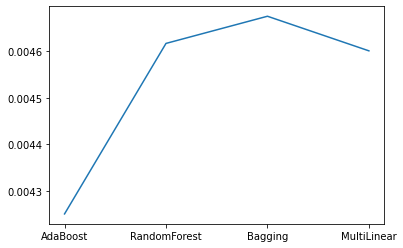

In [43]:
my_xticks = ['AdaBoost','RandomForest','Bagging','MultiLinear']
plt.plot(my_xticks,mse_table)
plt.show()